## ARIMA-model

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import nsdiffs
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics

from sklearn.model_selection import train_test_split

In [129]:
var_set = pd.read_csv('var_set.csv', parse_dates=[0],index_col=[0])

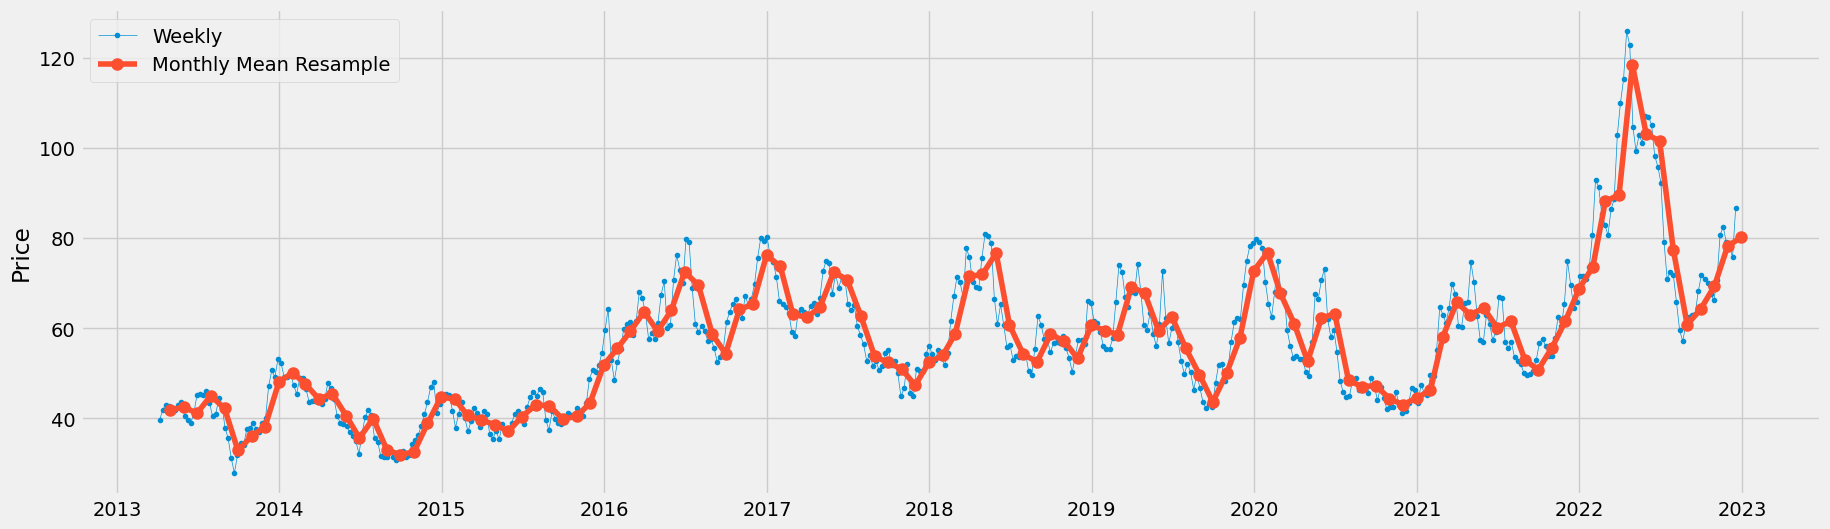

In [130]:
y = var_set['SalmonPrice']
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Price')
ax.legend();
plt.savefig('Figures/ARIMA/MonthlyMeanPlot.png')

In [131]:
var_set.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 507 entries, 2013-04-07 to 2022-12-18
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SalmonPrice   507 non-null    float64
 1   CodPrice      507 non-null    float64
 2   HalibutPrice  507 non-null    float64
 3   CPI           507 non-null    float64
 4   TWI           507 non-null    float64
dtypes: float64(5)
memory usage: 23.8 KB


In [132]:
train_all, test_all = train_test_split(var_set, test_size=50, shuffle=False)

In [133]:
train = train_all.SalmonPrice
test = test_all.SalmonPrice

In [233]:
len(train)

457

In [134]:
dftest1 = adfuller(train, autolag="AIC") 

#print(dftest1)
siglevel = dftest1[1]

if dftest1[1] < 0.05:
  print("Salmon price is stationary.")
else:
  print("Sig-level is:",siglevel.round(5),"\nSalmon price is not stationary at a 5% sig-level.")

Salmon price is stationary.


In [135]:
print(dftest1[1])

0.024060980547540554


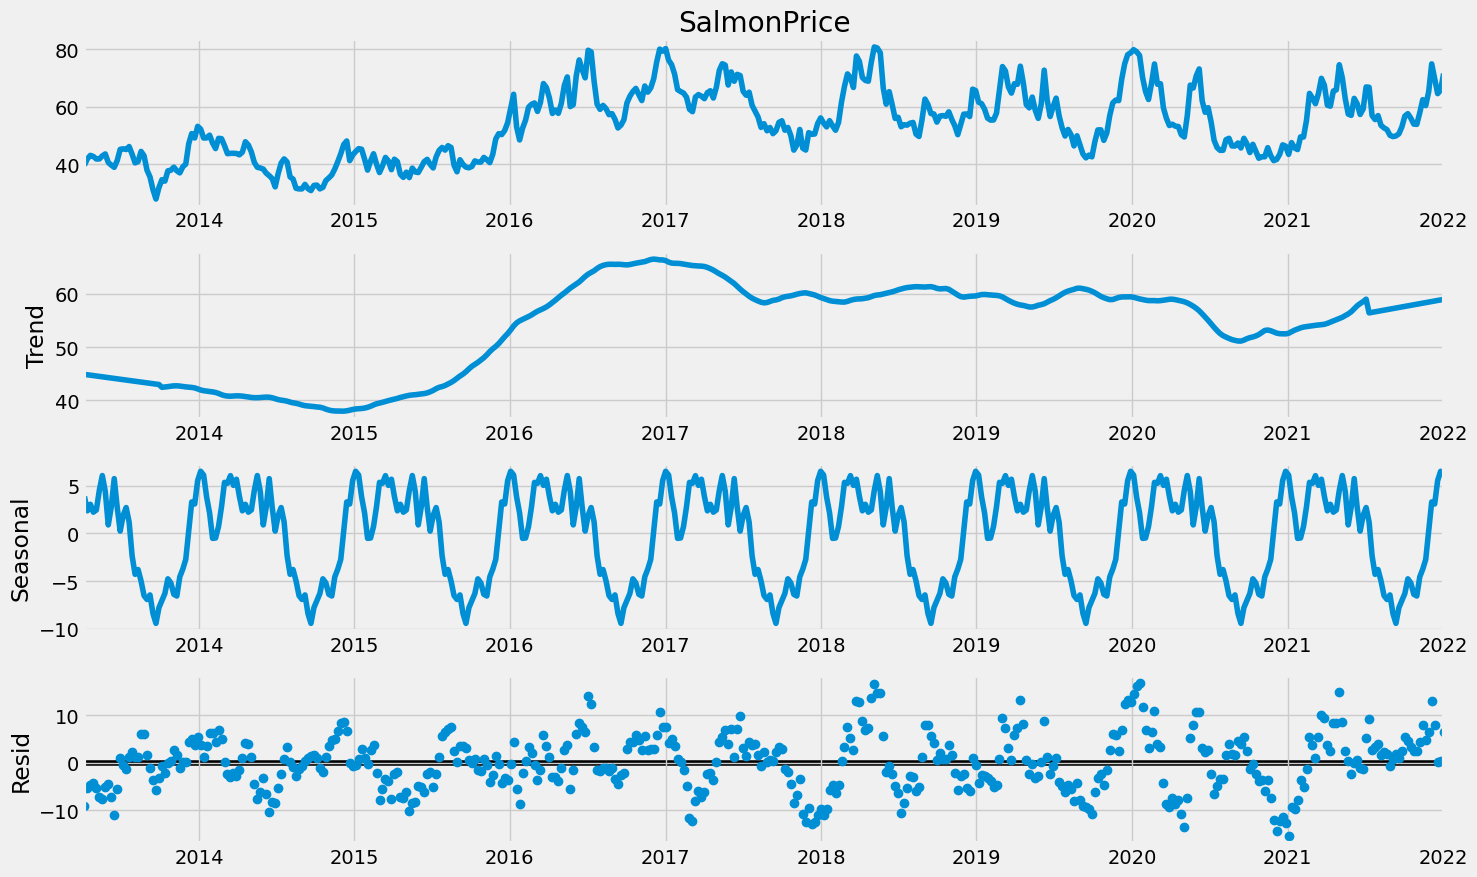

In [136]:
decomposition = sm.tsa.seasonal_decompose(train, model='additive',extrapolate_trend='freq')
#fig.set_linewidth(0.1)
fig = decomposition.plot()
fig.set_size_inches(15,9)
fig.tight_layout()
plt.savefig('Figures/ARIMA/Decomposition.png')
plt.show()

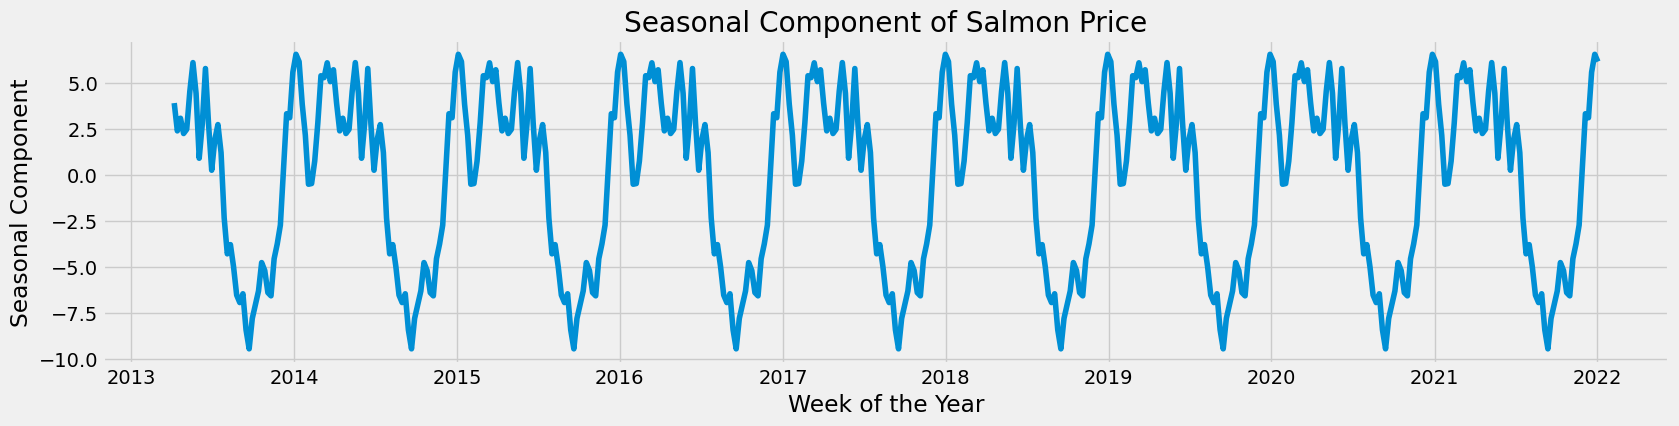

In [137]:
#seasonal = decomposition.seasonal
fig, ax = plt.subplots(figsize=(18,4))
ax.plot(decomposition.seasonal)
ax.set_xlabel('Week of the Year')
ax.set_ylabel('Seasonal Component')
ax.set_title('Seasonal Component of Salmon Price')
plt.savefig('Figures/ARIMA/SeasonalDecompose.png')
plt.show()

In [138]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


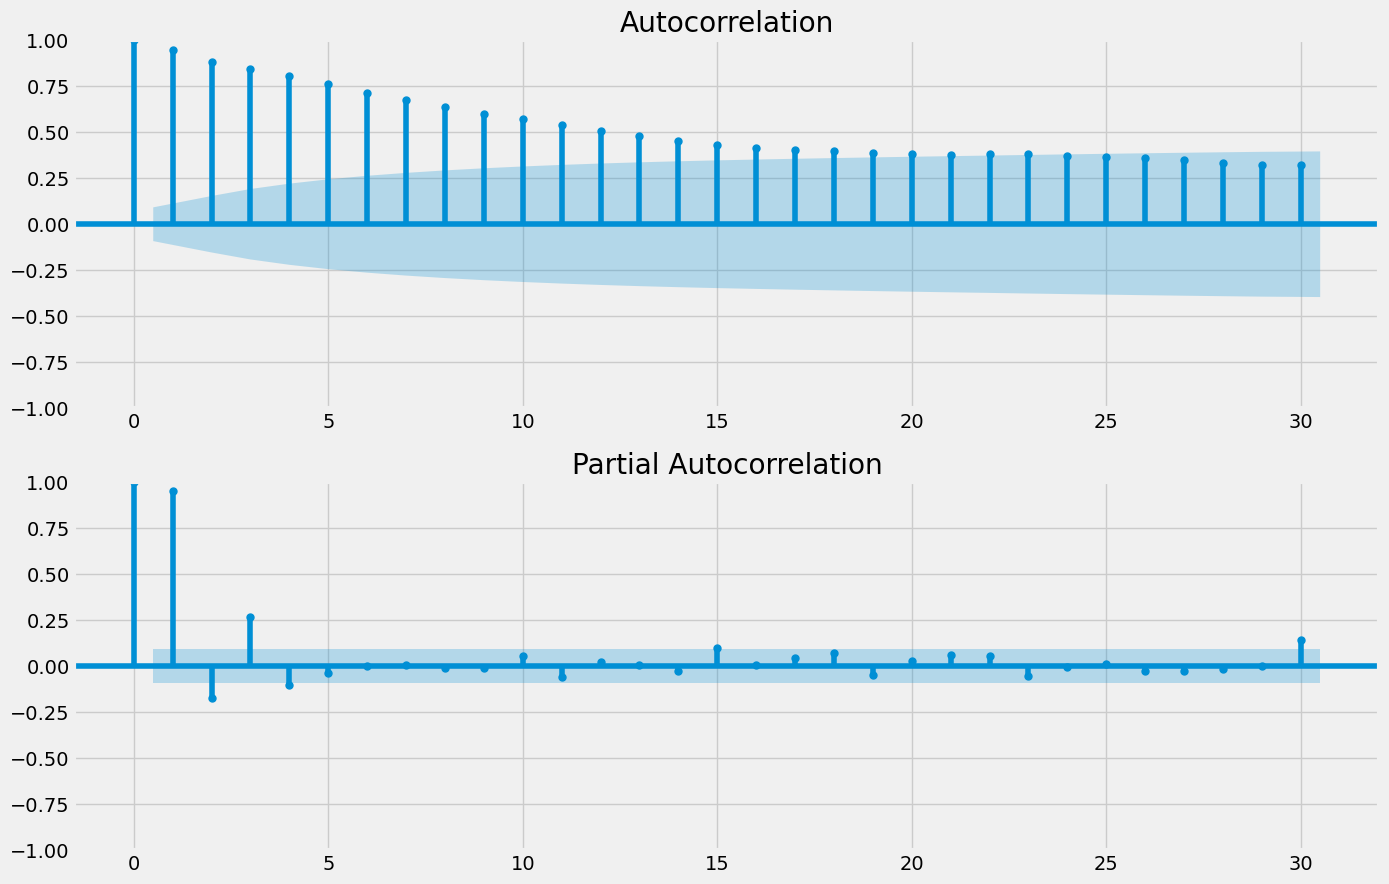

In [139]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
plot_acf(train, ax=ax[0], lags=30)
plot_pacf(train, ax=ax[1], lags=30)

plt.savefig('Figures/ARIMA/OriginalACF-PACF_30.png')
plt.show()

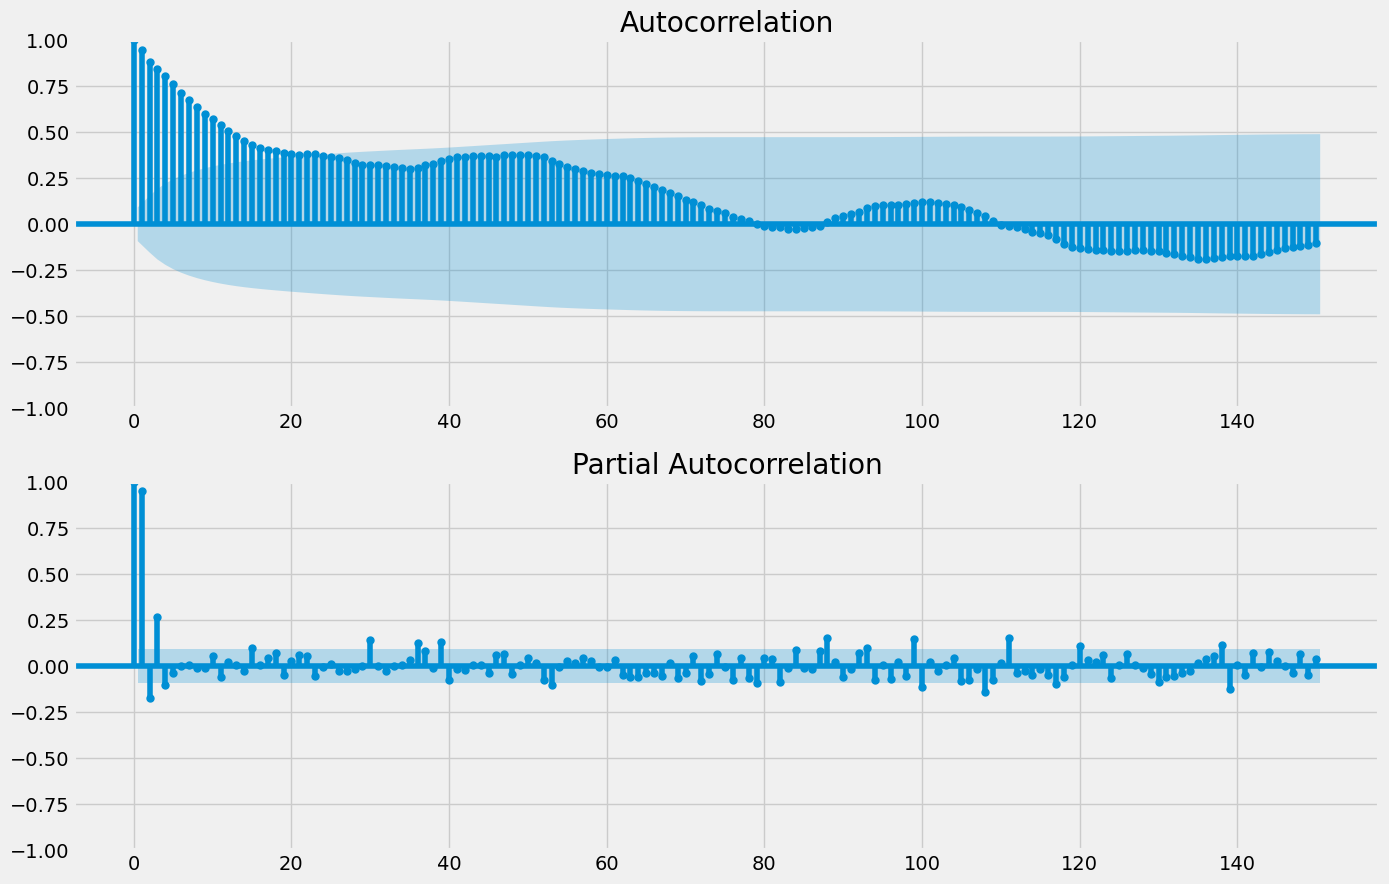

In [140]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
plot_acf(train, ax=ax[0], lags=150)
plot_pacf(train, ax=ax[1], lags=150)

plt.savefig('Figures/ARIMA/OriginalACF-PACF_150.png')
plt.show()

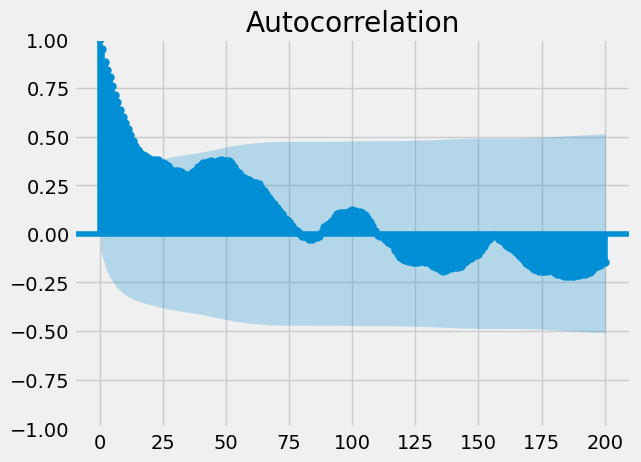

In [141]:

plot_acf(train, lags=200)

plt.show()

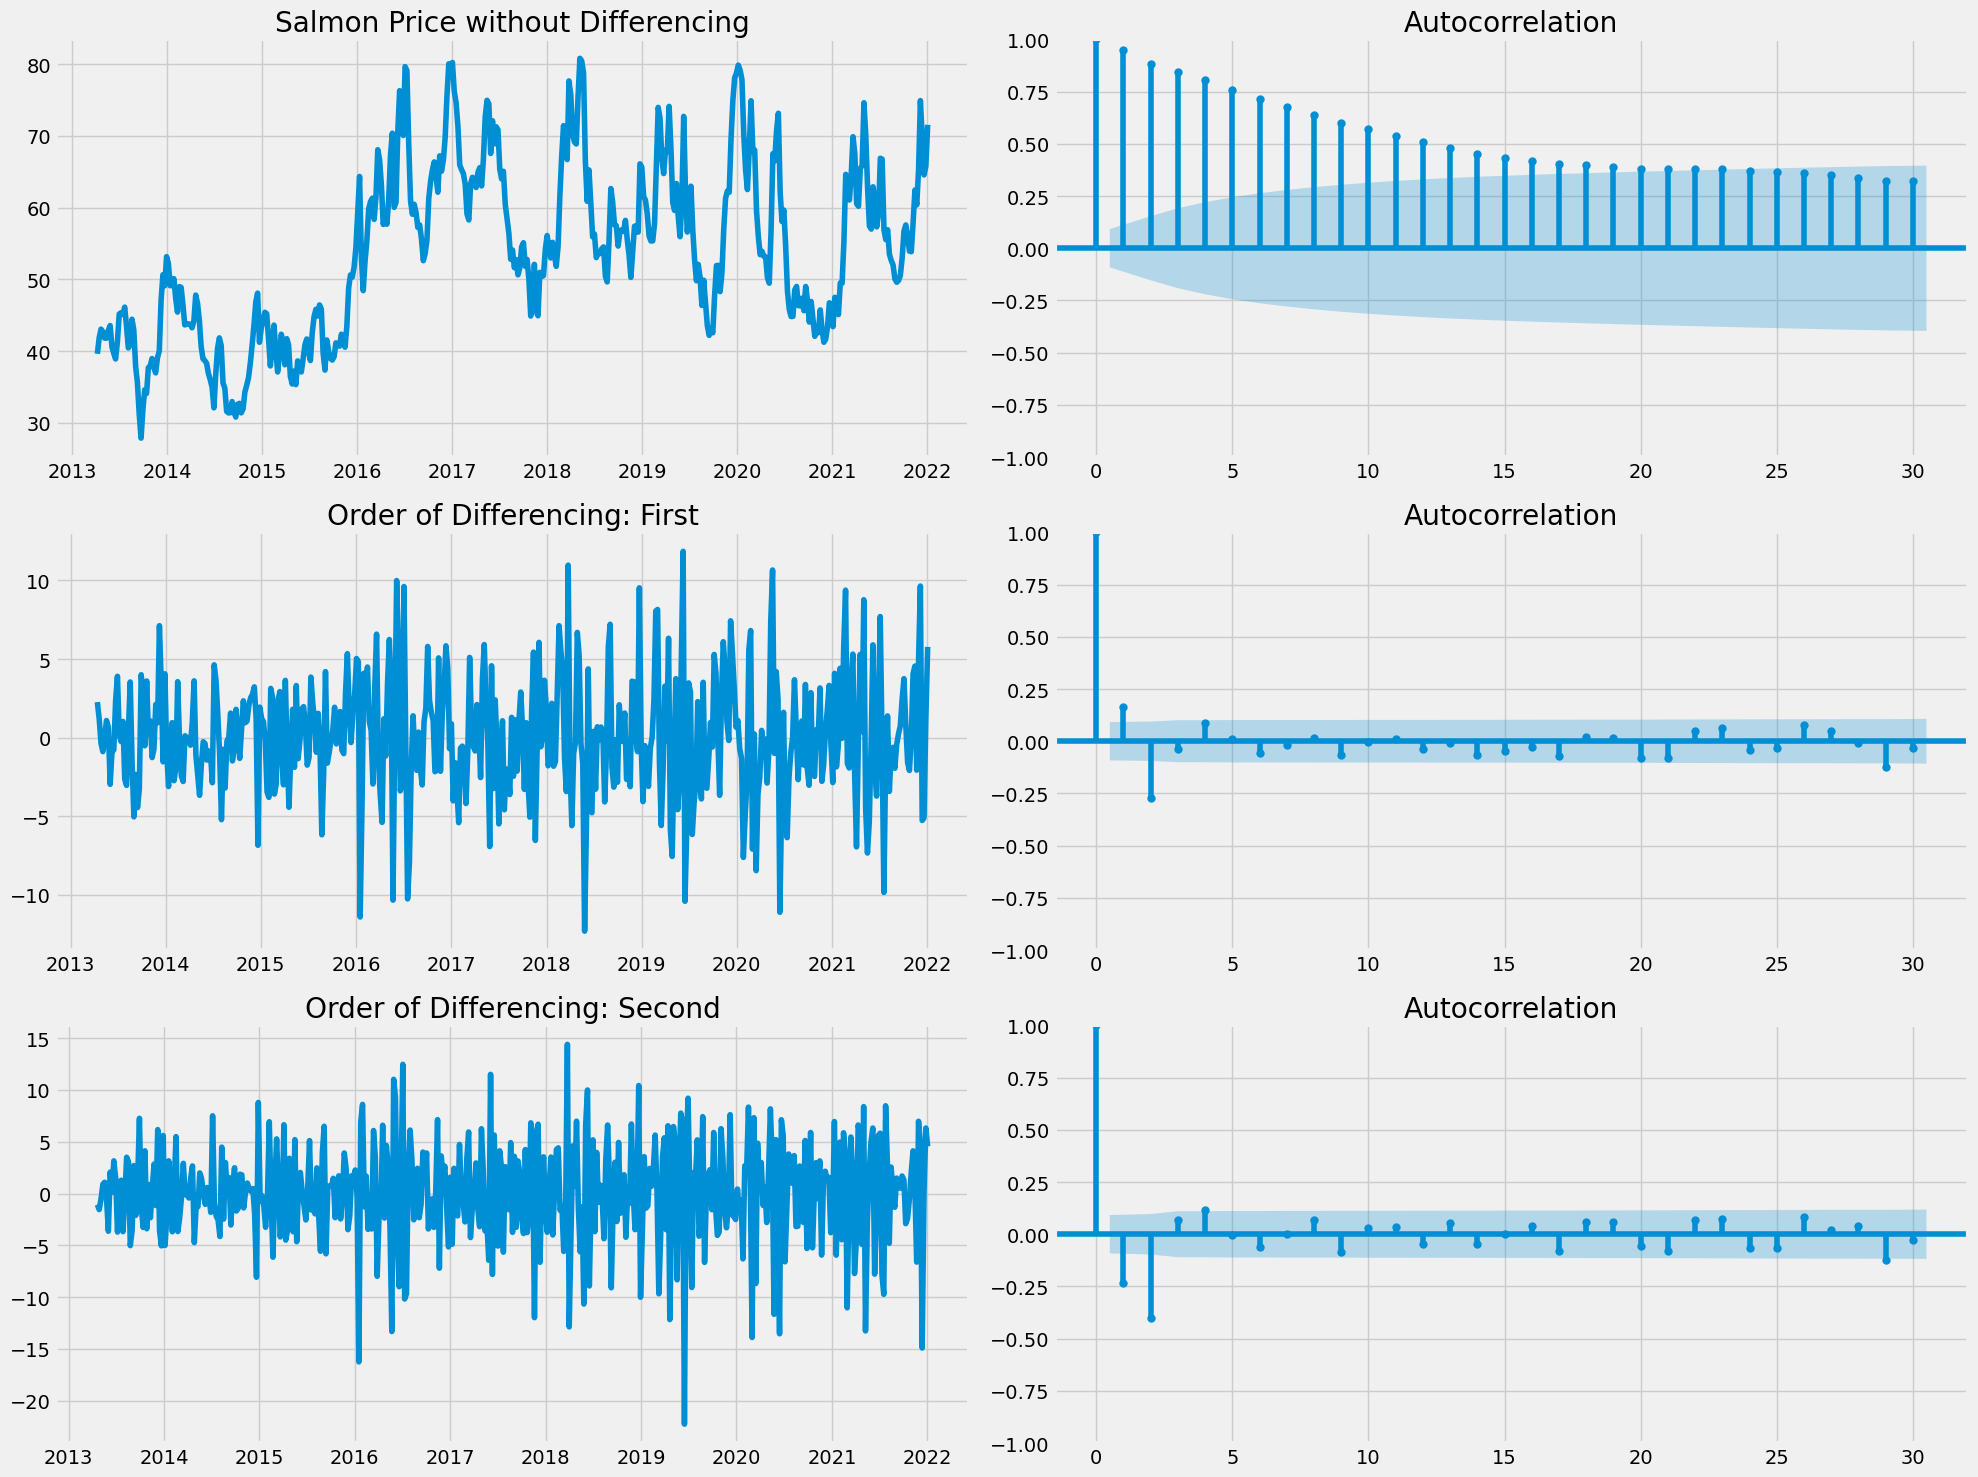

In [142]:
# The Genuine Series  
fig, axes = plt.subplots(3, 2, figsize=(20, 15))  
axes[0, 0].plot(train); axes[0, 0].set_title('Salmon Price without Differencing')  
plot_acf(train, ax = axes[0, 1], lags=30)  
  
# Order of Differencing: First  
axes[1, 0].plot(train.diff()); axes[1, 0].set_title('Order of Differencing: First')  
plot_acf(train.diff().dropna(), ax = axes[1, 1], lags=30)  
  
# Order of Differencing: Second  
axes[2, 0].plot(train.diff().diff()); axes[2, 0].set_title('Order of Differencing: Second')  
plot_acf(train.diff().diff().dropna(), ax = axes[2, 1], lags=30)  

plt.tight_layout()
  
plt.savefig('Figures/ARIMA/Diff1_ACF_30.png')
plt.show()

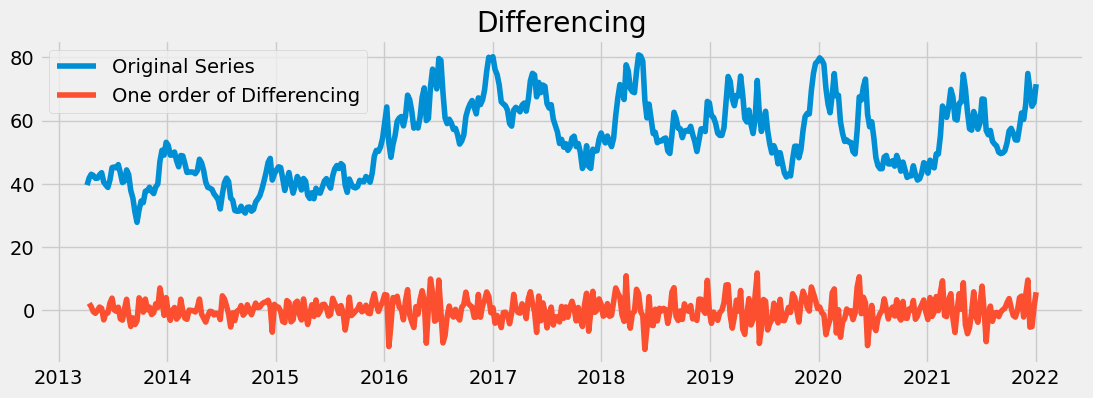

In [143]:
plt.figure(figsize=(12,4))
plt.plot(train, label='Original Series')
plt.plot(train.diff(1), label='One order of Differencing')
plt.title('Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.legend()

plt.show()

In [144]:
adftest = ndiffs(train, test = 'adf', alpha=0.05)
print("ADF Test: ", adftest)

ADF Test:  0


In [145]:
dftestdiff = adfuller(train.diff().dropna(), autolag="AIC") 

print(dftestdiff[1])
siglevel = dftestdiff[1]

if dftestdiff[1] < 0.05:
  print("Salmon price is stationary.")
else:
  print("Sig-level is:",siglevel.round(5),"\nSalmon price is not stationary at a 5% sig-level.")

3.863882167220082e-24
Salmon price is stationary.


In [146]:
std_salmon = train.describe()[2]
std_slamondiff1 = train.diff(1).dropna().describe()[2]
std_slamondiff2 = train.diff(2).dropna().describe()[2]
std_slamondiff3 = train.diff(3).dropna().describe()[2]

In [147]:
std_salmondf = pd.DataFrame({'Standard deviation':[std_salmon]}, index=['No differencing'])

In [148]:
std_salmondf = std_salmondf.append(pd.DataFrame({'Standard deviation':[std_slamondiff1]},index=['First differencing']))

/var/folders/xy/_0zst1c12b9_m_438bw49zw40000gn/T/ipykernel_69901/1956071333.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  std_salmondf = std_salmondf.append(pd.DataFrame({'Standard deviation':[std_slamondiff1]},index=['First differencing']))


In [149]:
std_salmondf = std_salmondf.append(pd.DataFrame({'Standard deviation':[std_slamondiff2]},index=['Second differencing']))
std_salmondf = std_salmondf.append(pd.DataFrame({'Standard deviation':[std_slamondiff3]},index=['Third differencing']))

/var/folders/xy/_0zst1c12b9_m_438bw49zw40000gn/T/ipykernel_69901/4255809871.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  std_salmondf = std_salmondf.append(pd.DataFrame({'Standard deviation':[std_slamondiff2]},index=['Second differencing']))
/var/folders/xy/_0zst1c12b9_m_438bw49zw40000gn/T/ipykernel_69901/4255809871.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  std_salmondf = std_salmondf.append(pd.DataFrame({'Standard deviation':[std_slamondiff3]},index=['Third differencing']))


In [150]:
std_salmondf

,Standard deviation
No differencing,11.989141
First differencing,3.708461
Second differencing,5.661965
Third differencing,6.548135


In [151]:
std_salmondf.style.to_latex('Figures/ARIMA/StdDevTable.tex', hrules=True)

/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


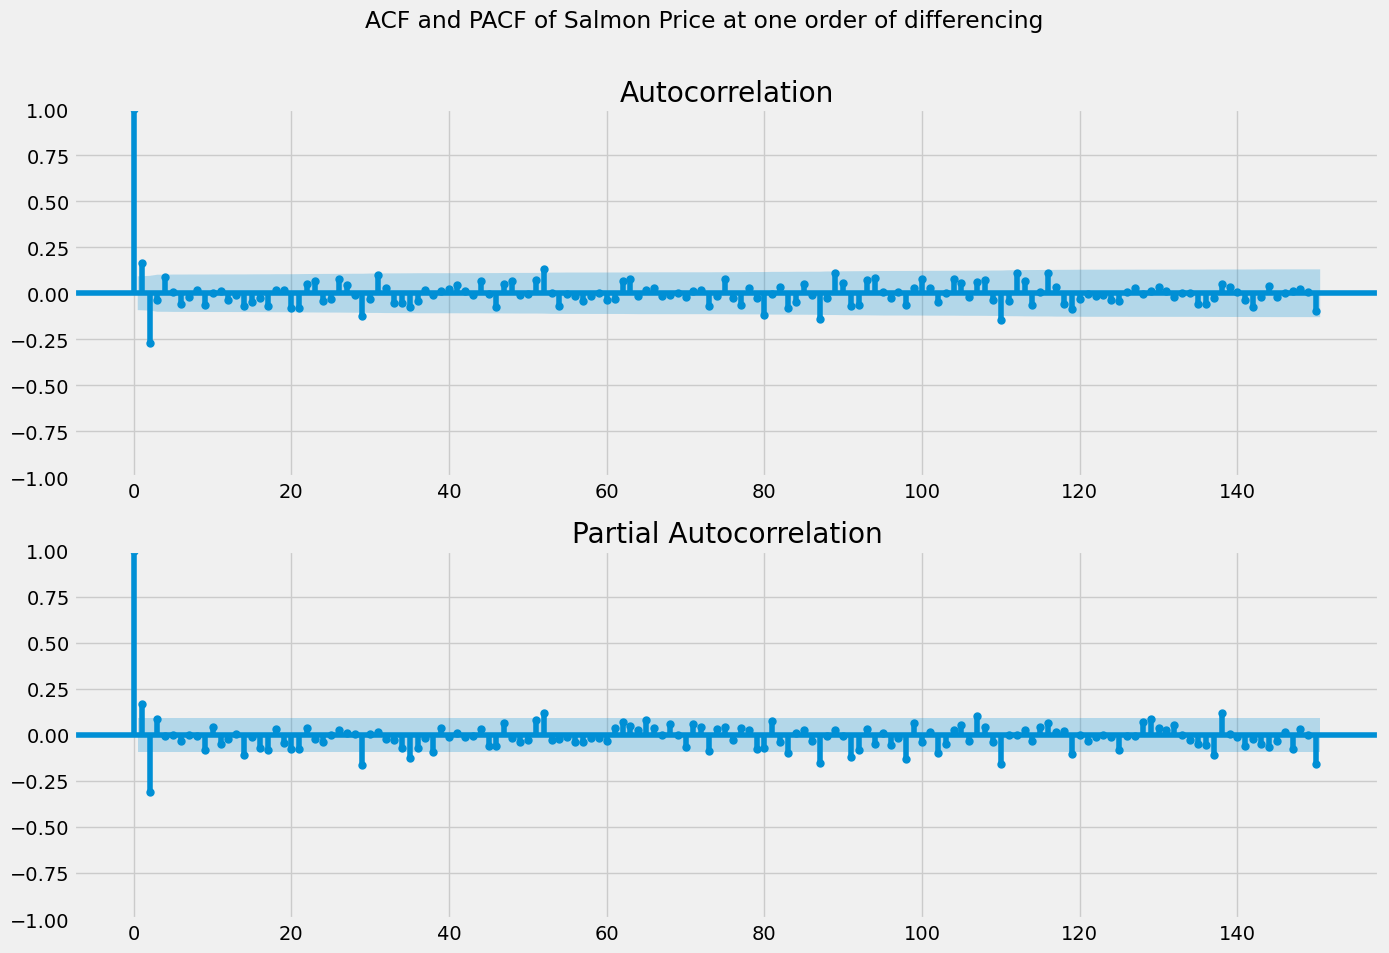

In [152]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
fig.suptitle('ACF and PACF of Salmon Price at one order of differencing')
plot_acf(train.diff().dropna(), ax=ax[0], lags=150)
plot_pacf(train.diff().dropna(), ax=ax[1], lags=150)

plt.savefig('Figures/ARIMA/DiffACF-PACF_150.png')
plt.show()

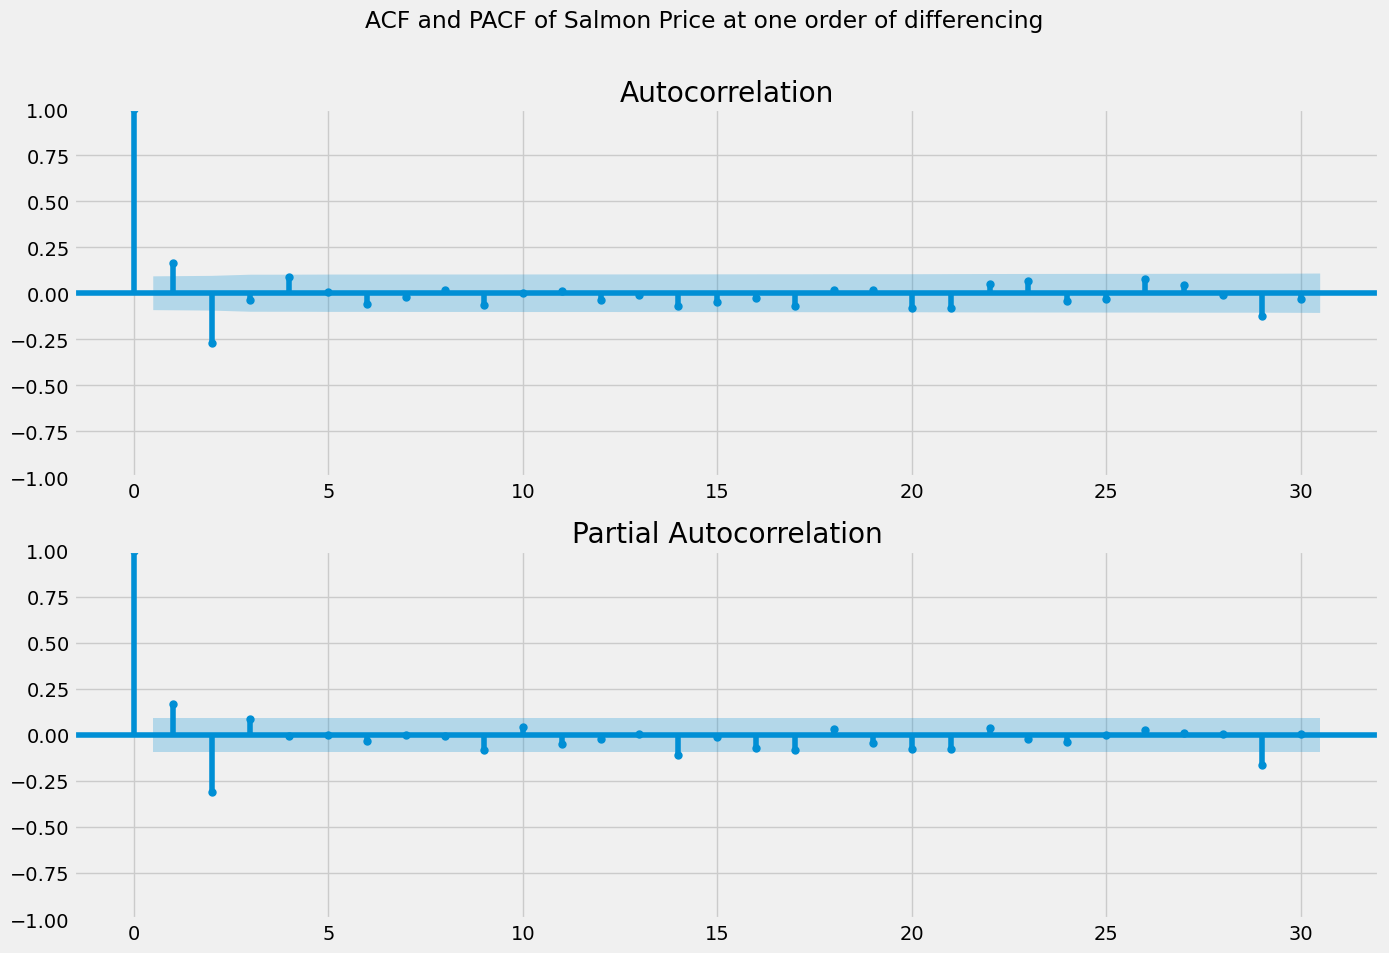

In [153]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
fig.suptitle('ACF and PACF of Salmon Price at one order of differencing')
plot_acf(train.diff().dropna(), ax=ax[0], lags=30)
plot_pacf(train.diff().dropna(), ax=ax[1], lags=30)

plt.savefig('Figures/ARIMA/DiffACF-PACF_30.png')
plt.show()

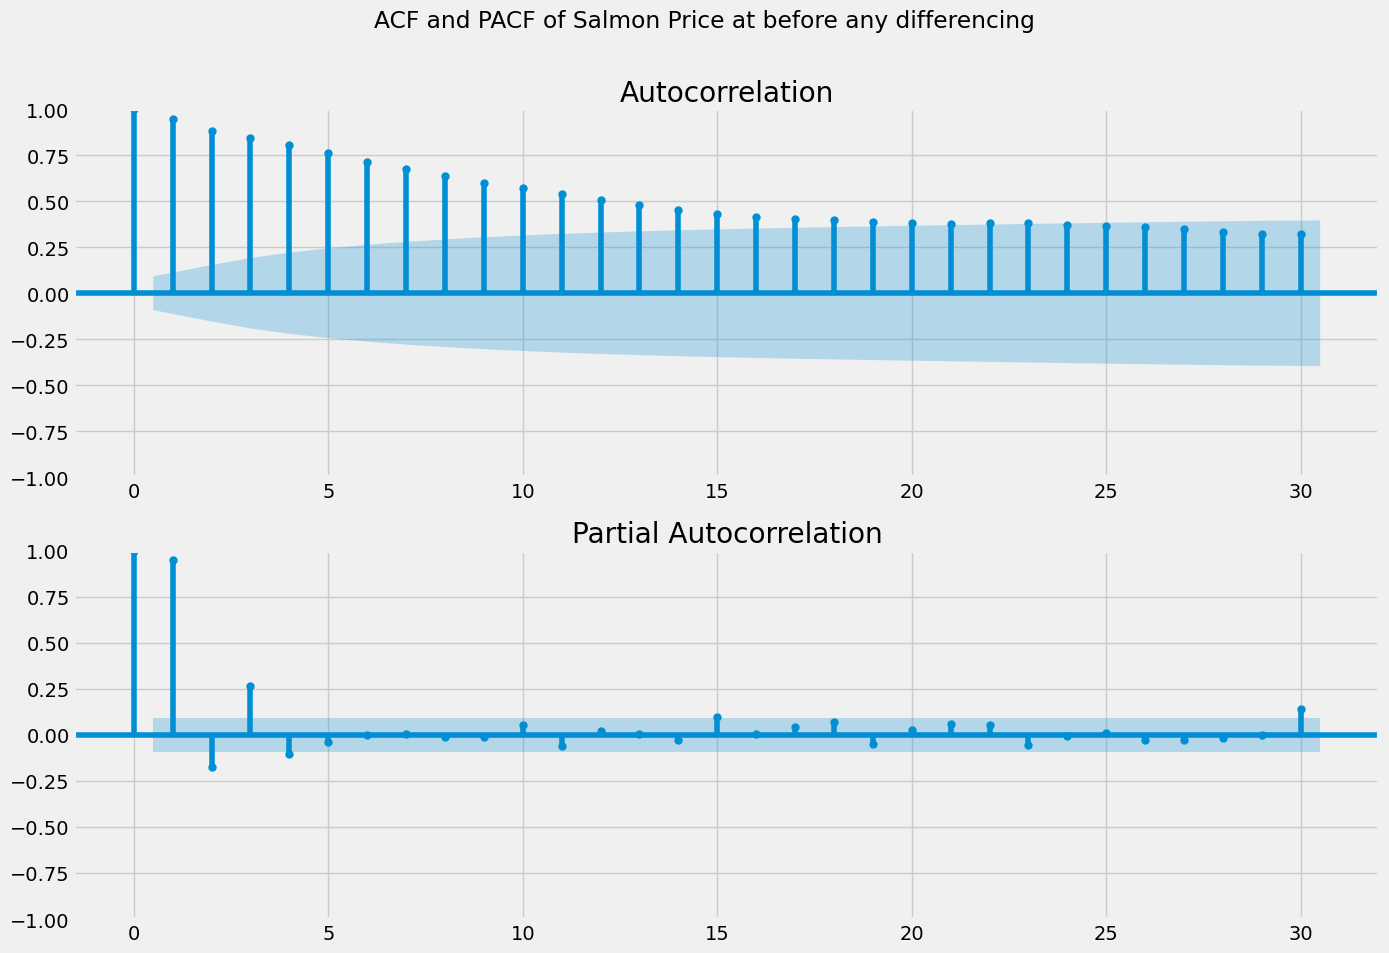

In [154]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
fig.suptitle('ACF and PACF of Salmon Price at before any differencing')
plot_acf(train, ax=ax[0], lags=30)
plot_pacf(train, ax=ax[1], lags=30)

plt.savefig('Figures/ARIMA/OrigACF-PACF_30.png')
plt.show()

In [155]:
# Estimating the seasonal differencing term, D
D = nsdiffs(train,
            m=52,  # commonly requires knowledge of dataset
            max_D=12,
            test='ocsb')  # -> 0

In [156]:
D

0

In [157]:
ARIMA_model_differenced = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         d=1, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2452.397, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2492.354, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2481.571, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2464.717, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2490.517, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2436.796, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2437.976, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2438.735, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2438.764, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2440.386, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2436.756, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2434.930, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2436.178, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=2436.912, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]          

In [158]:
ARIMA_model_nodiff = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         d=None, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2456.542, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3570.286, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2492.042, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3065.917, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4963.371, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2448.145, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2476.540, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=2437.688, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2440.016, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2439.433, Time=0.13 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2441.744, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=2447.491, Time=0.05 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 0.840 seconds


In [159]:
# ###SARIMA_model_diff = pm.auto_arima(train, start_p=1, start_q=1,
#                          test='adf',
#                          max_p=3, max_q=3, 
#                          m=52, #52 is the frequency of the cycle
#                          start_P=0, 
#                          seasonal=True, #set to seasonal
#                          d=1, 
#                          D=None, #order of the seasonal differencing
#                          trace=True,
#                          error_action='ignore',  
#                          suppress_warnings=True, 
#                          stepwise=True)

/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


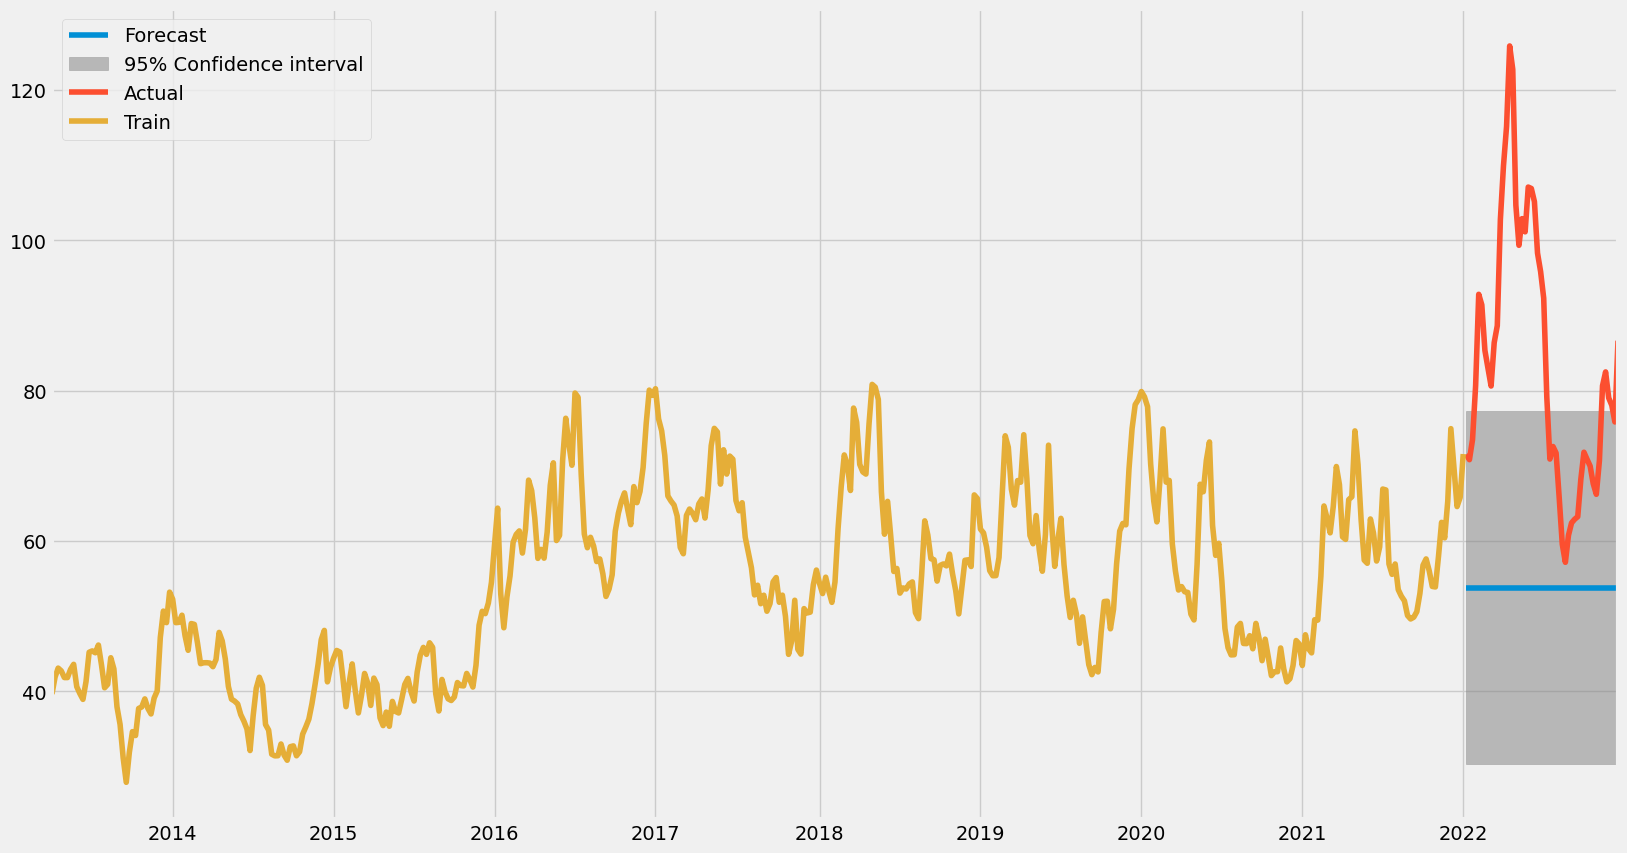

In [160]:
ARIMA_000 = ARIMA(train, order=(0,0,0))

ARIMA_000_fit = ARIMA_000.fit()
fig, ax = plt.subplots(figsize=(18,10))
plot_predict(ARIMA_000_fit, start=457, end=506, ax=ax)
test.plot(ax=ax, label='Actual')
train.plot(ax=ax)
plt.legend(['Forecast', '95% Confidence interval', 'Actual', 'Train'])
plt.savefig('Figures/ARIMA/ARIMA_0_0_0.png')
plt.show()

In [161]:
ARIMA_000_forecasts = ARIMA_000_fit.forecast(50)
RMSE000 = np.sqrt(metrics.mean_squared_error(test, ARIMA_000_forecasts))

In [162]:
RMSE_df = pd.DataFrame({'RMSE':[RMSE000]}, index=['ARIMA(0,0,0)'])

/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


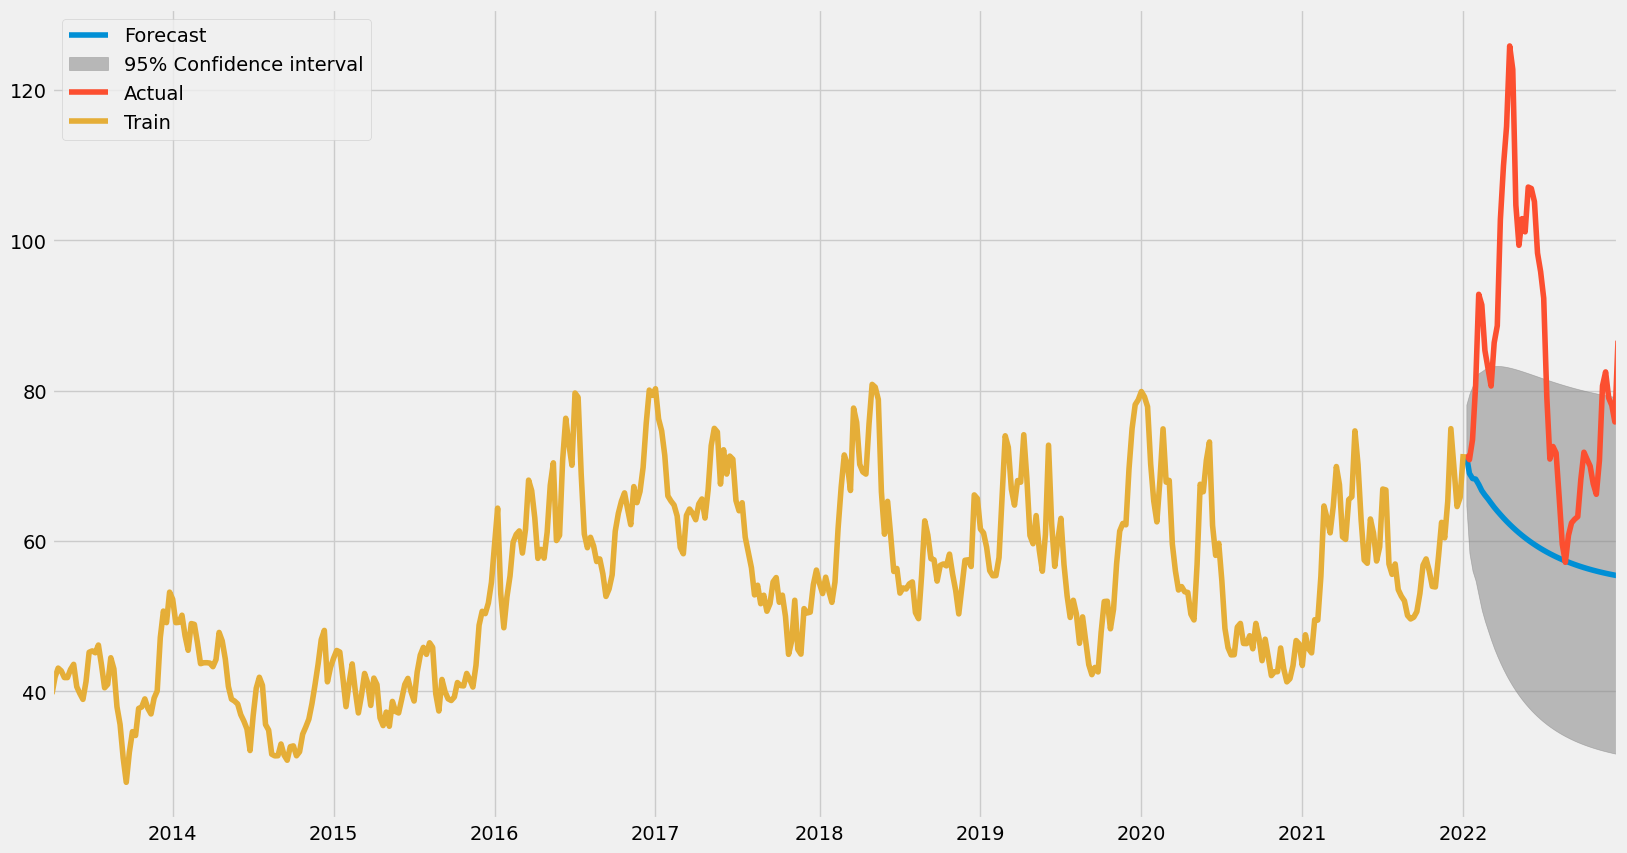

In [163]:
ARIMA_400 = ARIMA(train, order=(4,0,0))

ARIMA_400_fit = ARIMA_400.fit()
fig, ax = plt.subplots(figsize=(18,10))
plot_predict(ARIMA_400_fit, start=457, end=506, ax=ax)
test.plot(ax=ax, label='Actual')
train.plot(ax=ax)
plt.legend(['Forecast', '95% Confidence interval', 'Actual', 'Train'])
plt.savefig('Figures/ARIMA/ARIMA_4_0_0.png')
plt.show()

In [164]:
ARIMA_400_forecasts = ARIMA_400_fit.forecast(50)
RMSE400 = np.sqrt(metrics.mean_squared_error(test, ARIMA_400_forecasts))

In [165]:
RMSE_df = RMSE_df.append(pd.DataFrame({'RMSE':[RMSE400]}, index=['ARIMA(4,0,0)']))

/var/folders/xy/_0zst1c12b9_m_438bw49zw40000gn/T/ipykernel_69901/2114744558.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RMSE_df = RMSE_df.append(pd.DataFrame({'RMSE':[RMSE400]}, index=['ARIMA(4,0,0)']))


/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


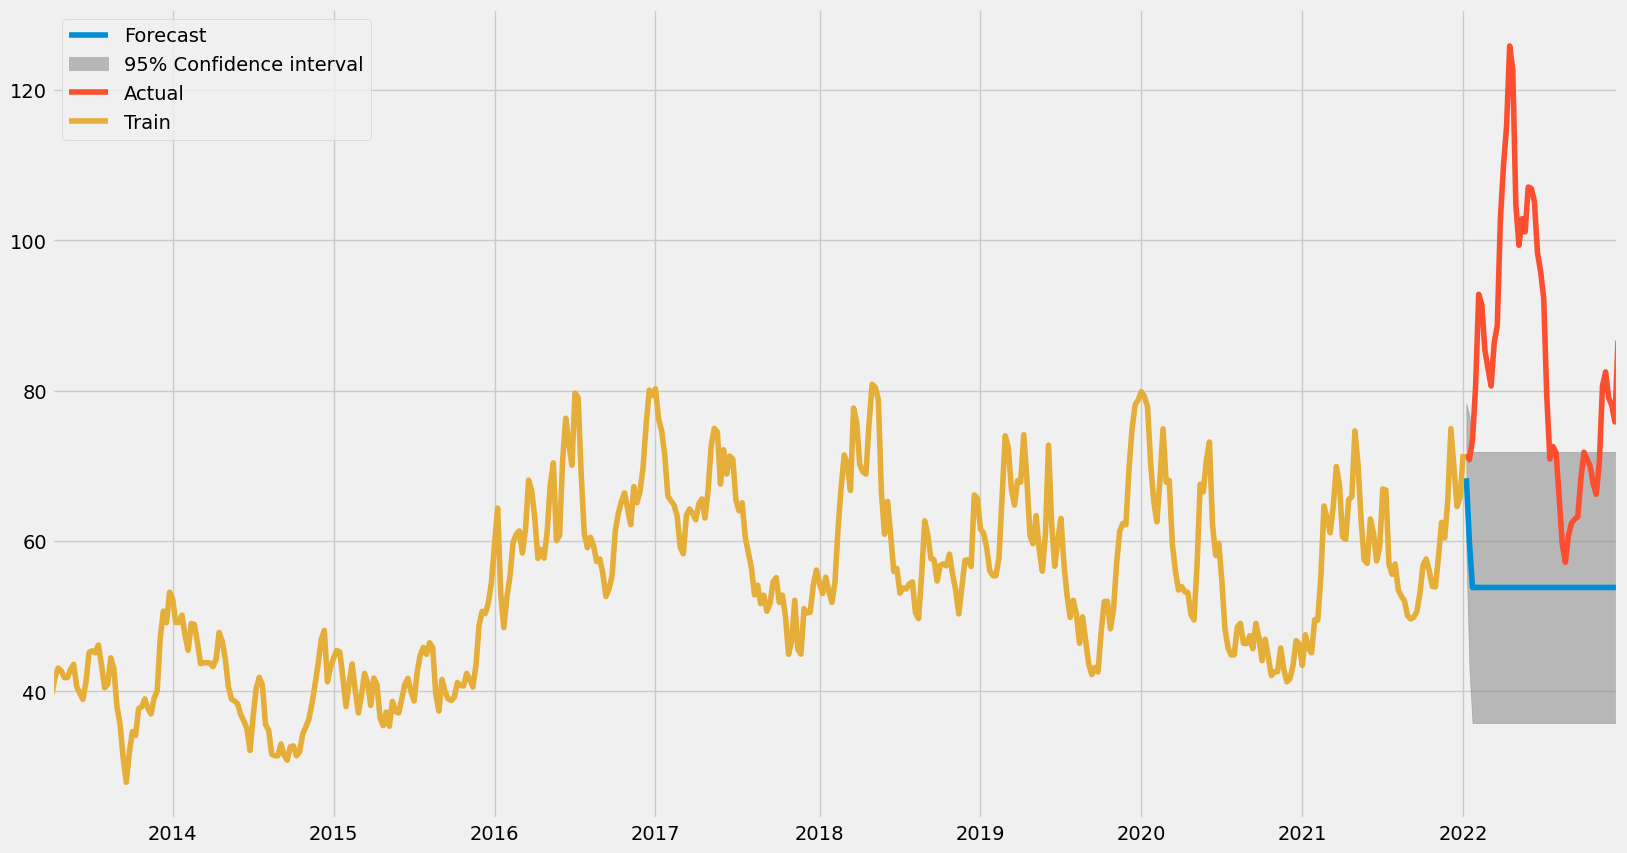

In [166]:
ARIMA_002 = ARIMA(train, order=(0,0,2))

ARIMA_002_fit = ARIMA_002.fit()
fig, ax = plt.subplots(figsize=(18,10))
plot_predict(ARIMA_002_fit, start=457, end=506, ax=ax)
test.plot(ax=ax, label='Actual')
train.plot(ax=ax)
plt.legend(['Forecast', '95% Confidence interval', 'Actual', 'Train'])
plt.savefig('Figures/ARIMA/ARIMA_0_0_2.png')
plt.show()

In [167]:
ARIMA_002_forecasts = ARIMA_002_fit.forecast(50)
RMSE002 = np.sqrt(metrics.mean_squared_error(test, ARIMA_002_forecasts))
RMSE_df = RMSE_df.append(pd.DataFrame({'RMSE':[RMSE002]}, index=['ARIMA(0,0,2)']))

/var/folders/xy/_0zst1c12b9_m_438bw49zw40000gn/T/ipykernel_69901/3317211454.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RMSE_df = RMSE_df.append(pd.DataFrame({'RMSE':[RMSE002]}, index=['ARIMA(0,0,2)']))


/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


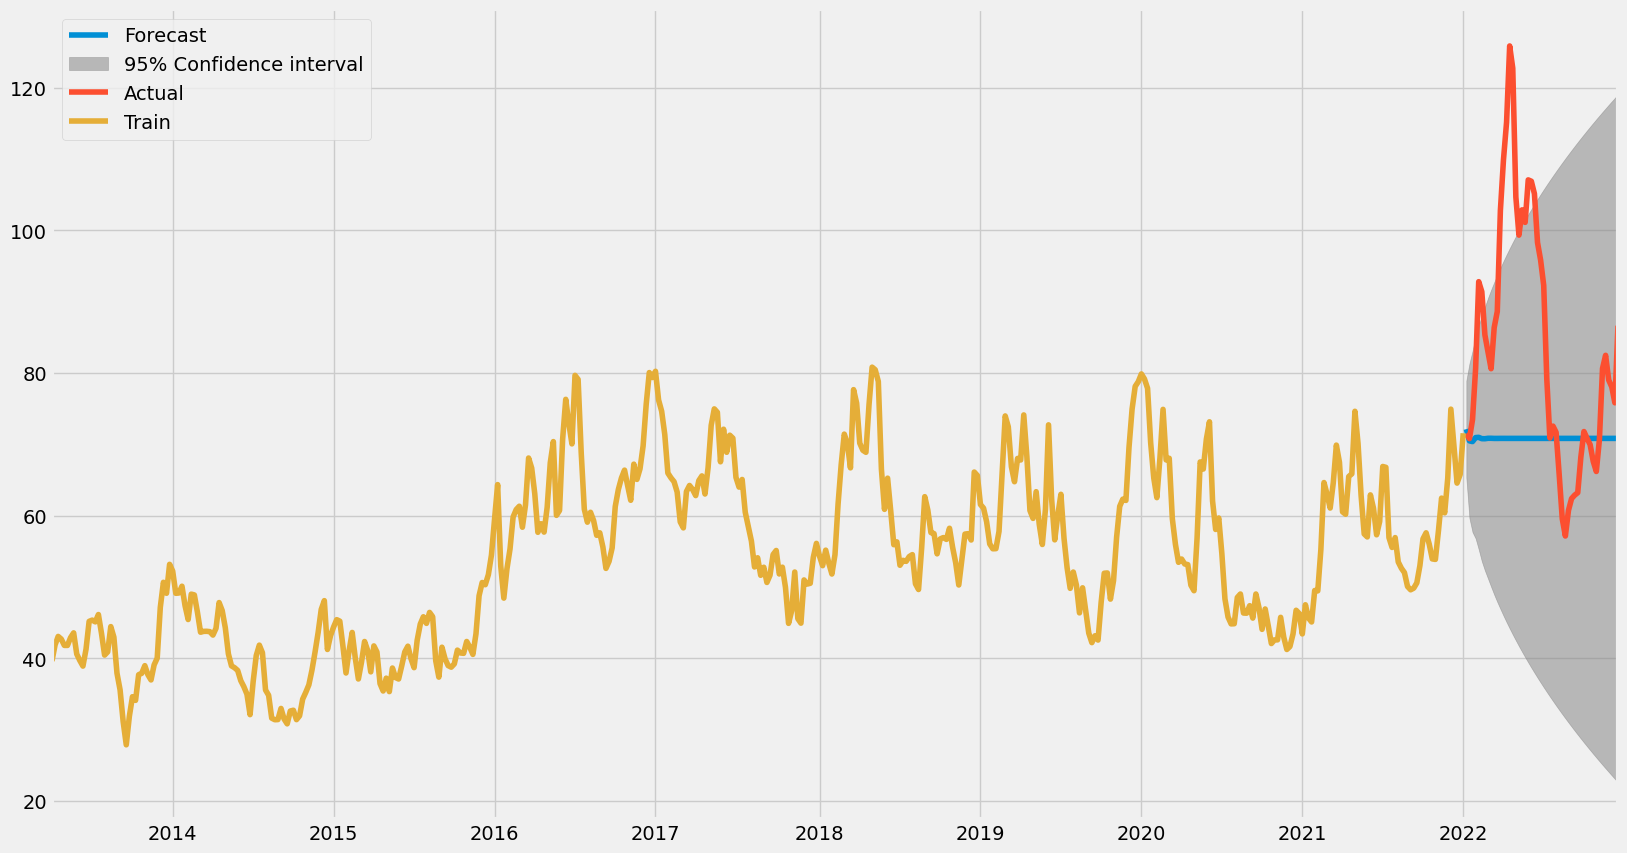

In [168]:
ARIMA_310 = ARIMA(train, order=(3,1,0))

ARIMA_310_fit = ARIMA_310.fit()
fig, ax = plt.subplots(figsize=(18,10))
plot_predict(ARIMA_310_fit, start=457, end=506, ax=ax)
test.plot(ax=ax, label='Actual')
train.plot(ax=ax)
plt.legend(['Forecast', '95% Confidence interval', 'Actual', 'Train'])
plt.savefig('Figures/ARIMA/ARIMA_3_1_0.png')
plt.show()

In [169]:
ARIMA_310_forecasts = ARIMA_310_fit.forecast(50)
RMSE310 = np.sqrt(metrics.mean_squared_error(test, ARIMA_310_forecasts))
RMSE_df = RMSE_df.append(pd.DataFrame({'RMSE':[RMSE310]}, index=['ARIMA(3,1,0)']))

/var/folders/xy/_0zst1c12b9_m_438bw49zw40000gn/T/ipykernel_69901/855569000.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RMSE_df = RMSE_df.append(pd.DataFrame({'RMSE':[RMSE310]}, index=['ARIMA(3,1,0)']))


/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


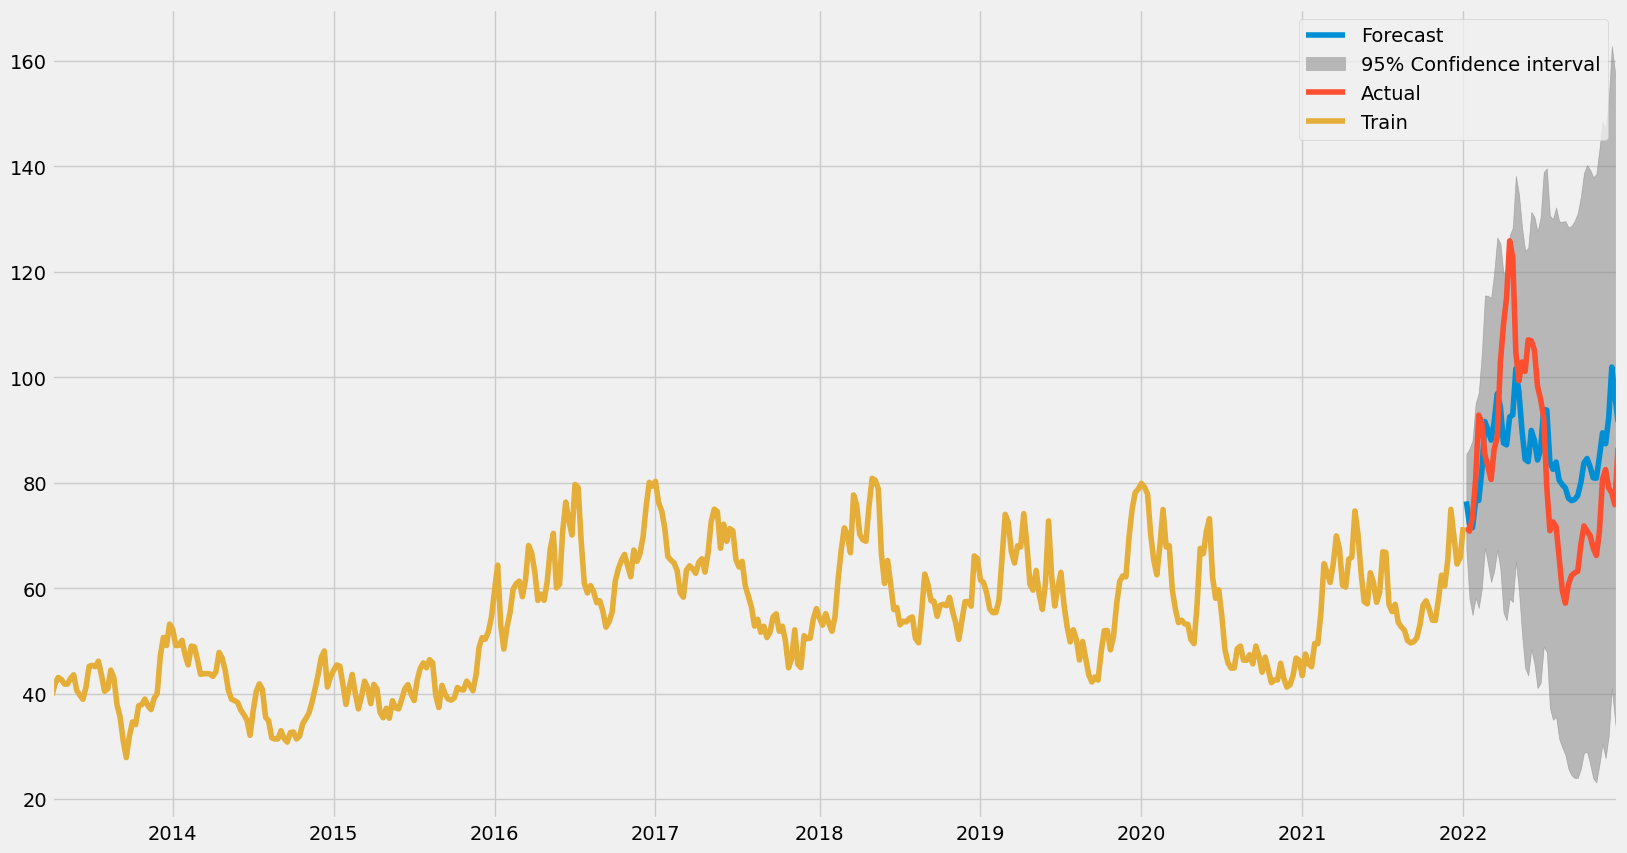

In [170]:
SARIMAX_diff = SARIMAX(train, order=(3,1,0), seasonal_order=(0,1,0,52))

SARIMA_diff_fit = SARIMAX_diff.fit(disp=False)
fig, ax = plt.subplots(figsize=(18,10))
plot_predict(SARIMA_diff_fit, start=457, end=506, ax=ax)
test.plot(ax=ax, label='Actual')
train.plot(ax=ax)
plt.legend(['Forecast', '95% Confidence interval', 'Actual', 'Train'])
plt.savefig('Figures/ARIMA/SARIMA_3_1_0_0_1_0_52.png')
plt.show()

In [171]:
SARIMA_diff_forecasts = SARIMA_diff_fit.forecast(50)
RMSE_SARIMA = np.sqrt(metrics.mean_squared_error(test, SARIMA_diff_forecasts))
RMSE_df = RMSE_df.append(pd.DataFrame({'RMSE':[RMSE_SARIMA]}, index=['SARIMA(3,1,0)(0,1,0,52)']))

/var/folders/xy/_0zst1c12b9_m_438bw49zw40000gn/T/ipykernel_69901/2807353231.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RMSE_df = RMSE_df.append(pd.DataFrame({'RMSE':[RMSE_SARIMA]}, index=['SARIMA(3,1,0)(0,1,0,52)']))


In [172]:
RMSE_df

,RMSE
"ARIMA(0,0,0)",34.571019
"ARIMA(4,0,0)",28.701332
"ARIMA(0,0,2)",34.420344
"ARIMA(3,1,0)",21.521569
"SARIMA(3,1,0)(0,1,0,52)",14.833392


In [173]:
test_pred_df = test.to_frame().join(SARIMA_diff_forecasts.to_frame(), lsuffix='_test', rsuffix='_forecast')

In [174]:
test_pred_df = test_pred_df.rename(columns={'SalmonPrice' :'Actual Price', 'predicted_mean' :'Forecast'})

In [175]:
test_pred_df

,Actual Price,Forecast
2022-01-09,71.52,76.453168
2022-01-16,70.81,72.233830
2022-01-23,73.48,71.472279
2022-01-30,80.66,76.607507
2022-02-06,92.82,76.629992
2022-02-13,91.41,82.220853
2022-02-20,85.35,91.577103
2022-02-27,82.96,89.993457
2022-03-06,80.61,88.071227
2022-03-13,86.38,91.571147


In [176]:
test_pred_df["Difference"] = test_pred_df["Actual Price"] - test_pred_df["Forecast"]

In [177]:
test_pred_df.head(20).style.to_latex('Figures/ARIMA/ForecastTable.tex', hrules=True)

In [178]:
%%capture
# Create a for-loop for testing different combinations of p, d, and q values for the ARIMA model and outputtig the RMSE for each combination in a dataframe

auto_RMSE_df = pd.DataFrame()

for p in range(0, 5):
    for d in range(0, 2):
        for q in range(0, 5):
            try:
                ARIMA_model = ARIMA(train, order=(p,d,q))
                ARIMA_fit = ARIMA_model.fit()
                ARIMA_forecasts = ARIMA_fit.forecast(50)
                RMSE = np.sqrt(metrics.mean_squared_error(test, ARIMA_forecasts))
                auto_RMSE_df = auto_RMSE_df.append(pd.DataFrame({'RMSE':[RMSE]}, index=['ARIMA('+str(p)+','+str(d)+','+str(q)+')']));
            except:
                continue


In [179]:
auto_RMSE_df.sort_values(by=['RMSE'], ascending=True).style.to_latex('Figures/ARIMA/AutoARIMAResults.tex', hrules=True)

/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


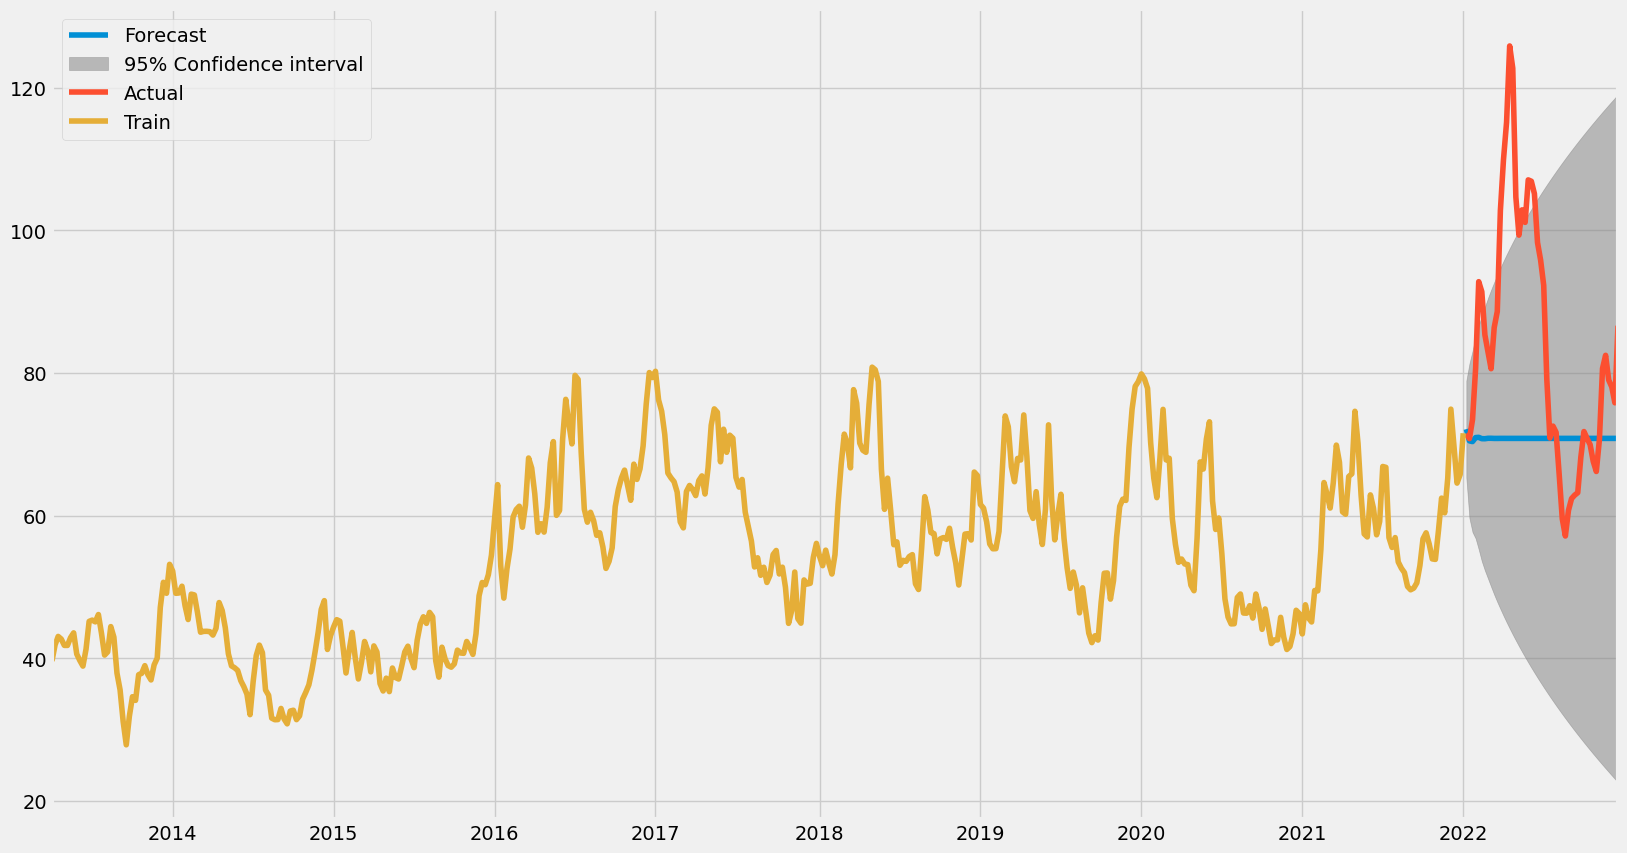

In [180]:
# Fit the best ARIMA model from above to a plot

ARIMA_310 = ARIMA(train, order=(3,1,0))

ARIMA_310_fit = ARIMA_310.fit()
fig, ax = plt.subplots(figsize=(18,10))
plot_predict(ARIMA_310_fit, start=457, end=506, ax=ax)
test.plot(ax=ax, label='Actual')
train.plot(ax=ax)
plt.legend(['Forecast', '95% Confidence interval', 'Actual', 'Train'])
plt.savefig('Figures/ARIMA/ARIMA_3_1_0.png')
plt.show()

In [181]:
%%capture
# Do the same but with SARIMA and seasonal_order of 52

SARIMA_RMSE_df2 = pd.DataFrame()

for p in range(0, 5):
    for d in range(0, 2):
        for q in range(0, 5):
            try:
                SARIMAX_model = SARIMAX(train, order=(p,d,q), seasonal_order=(0,1,0,52))
                SARIMAX_fit = SARIMAX_model.fit(disp=False)
                SARIMAX_forecasts = SARIMAX_fit.forecast(50)
                RMSE = np.sqrt(metrics.mean_squared_error(test, SARIMAX_forecasts))
                SARIMA_RMSE_df2 = SARIMA_RMSE_df2.append(pd.DataFrame({'RMSE':[RMSE]}, index=['SARIMA('+str(p)+','+str(d)+','+str(q)+')(0,1,0,52)']));
            except:
                continue;


In [212]:
SARIMA_RMSE_df2.sort_values(by=['RMSE'], ascending=True).head(10)

,RMSE
"SARIMA(2,1,0)(0,1,0,52)",14.829437
"SARIMA(3,1,4)(0,1,0,52)",14.833213
"SARIMA(3,1,0)(0,1,0,52)",14.833392
"SARIMA(3,1,2)(0,1,0,52)",14.837780
"SARIMA(3,1,1)(0,1,0,52)",14.839969
"SARIMA(4,1,0)(0,1,0,52)",14.840067
"SARIMA(4,1,2)(0,1,0,52)",14.840717
"SARIMA(2,1,2)(0,1,0,52)",14.840721
"SARIMA(3,1,3)(0,1,0,52)",14.840871
"SARIMA(4,1,1)(0,1,0,52)",14.840890


In [211]:
SARIMA_RMSE_df2.sort_values(by=['RMSE'], ascending=True).head(15).style.to_latex('Figures/ARIMA/AutoSARIMAResults.tex', hrules=True)

/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


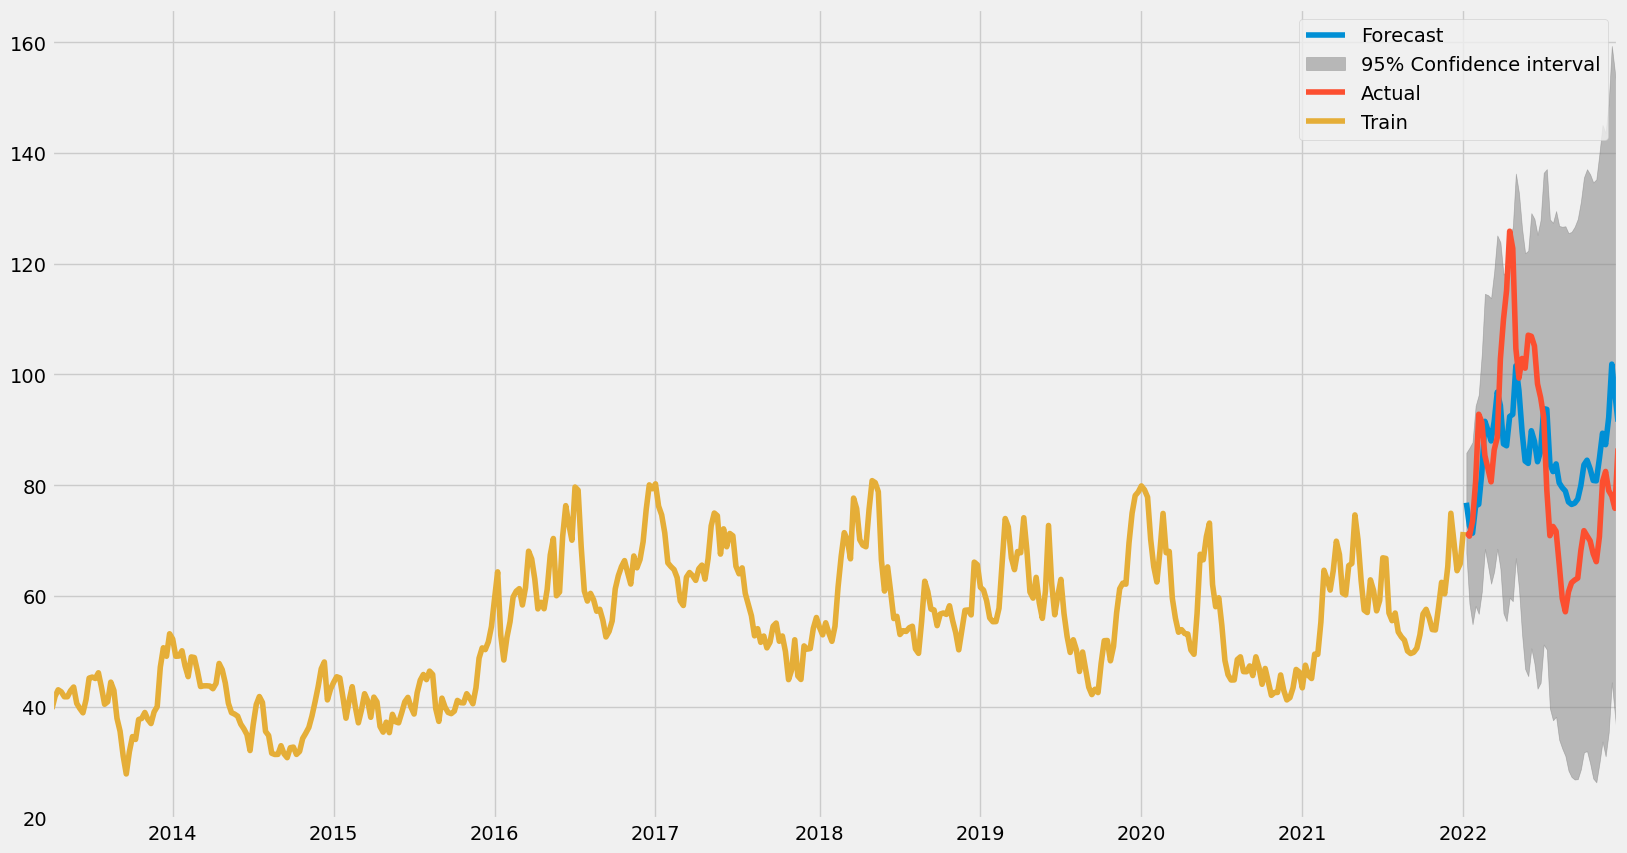

In [183]:
# Fit the best SARIMA model from above to a plot

SARIMAX_best = SARIMAX(train, order=(2,1,0), seasonal_order=(0,1,0,52))

SARIMAX_best_fit = SARIMAX_best.fit(disp=False)
fig, ax = plt.subplots(figsize=(18,10))
plot_predict(SARIMAX_best_fit, start=457, end=506, ax=ax)
test.plot(ax=ax, label='Actual')
train.plot(ax=ax)
plt.legend(['Forecast', '95% Confidence interval', 'Actual', 'Train'])
plt.savefig('Figures/ARIMA/SARIMA_2_1_0_0_1_0_52.png')
plt.show()


In [184]:
#Create sarimax model with the best parameters from above and train_all as exogenous variables included in the for-loop

# SARIMAX_RMSE_df = pd.DataFrame()

# P = 0
# D = 1
# Q = 0

# for p in range(0, 5):
#     for d in range(0, 2):
#         for q in range(0, 5):
#             try:
#                 SARIMAX_model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,52), exog=train_all)
#                 SARIMAX_fit = SARIMAX_model.fit(disp=False)
#                 SARIMAX_forecasts = SARIMAX_fit.forecast(50, exog=test_all)
#                 RMSE = np.sqrt(metrics.mean_squared_error(test, SARIMAX_forecasts))
#                 SARIMAX_RMSE_df = SARIMAX_RMSE_df.append(pd.DataFrame({'RMSE':[RMSE]}, index=['SARIMAX('+str(p)+','+str(d)+','+str(q)+')('+str(P)+','+str(D)+','+str(Q)+',52)']));
#             except:
#                 continue;

In [186]:
exogenous_train = train_all.drop(columns=['SalmonPrice'])
exogenous_test = test_all.drop(columns=['SalmonPrice'])

In [203]:
%%capture

# P=0
# D=1
# Q=0

# SARIMAX_uni_RMSE_df = pd.DataFrame()

# for p in range(0, 5):
#     for d in range(0, 2):
#         for q in range(0, 5):
#             for i in exogenous_train.columns:
#                 try:
#                     SARIMAX_model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,52), exog=exogenous_train[i])
#                     SARIMAX_fit = SARIMAX_model.fit(disp=False)
#                     SARIMAX_forecasts = SARIMAX_fit.forecast(50, exog=exogenous_test[i])
#                     RMSE = np.sqrt(metrics.mean_squared_error(test, SARIMAX_forecasts))
#                     SARIMAX_uni_RMSE_df = SARIMAX_uni_RMSE_df.append(pd.DataFrame({'RMSE':[RMSE]}, index=['SARIMAX('+str(p)+','+str(d)+','+str(q)+')('+str(P)+','+str(D)+','+str(Q)+',52)('+i+')']));         
#                 except:
#                     continue;


In [206]:
#SARIMAX_uni_RMSE_df.sort_values(by=['RMSE'], ascending=True).head(15)

,RMSE
"SARIMAX(4,1,4)(0,1,0,52)(TWI)",14.522850
"SARIMAX(3,1,3)(0,1,0,52)(TWI)",14.526102
"SARIMAX(2,1,3)(0,1,0,52)(TWI)",14.526103
"SARIMAX(3,1,1)(0,1,0,52)(TWI)",14.526189
"SARIMAX(4,1,0)(0,1,0,52)(TWI)",14.526196
"SARIMAX(4,1,1)(0,1,0,52)(TWI)",14.526219
"SARIMAX(4,1,2)(0,1,0,52)(TWI)",14.526225
"SARIMAX(3,1,0)(0,1,0,52)(TWI)",14.526306
"SARIMAX(2,1,2)(0,1,0,52)(TWI)",14.526316
"SARIMAX(3,1,2)(0,1,0,52)(TWI)",14.526352


In [205]:
#SARIMAX_uni_RMSE_df.sort_values(by=['RMSE'], ascending=True).head(20).style.to_latex('Figures/ARIMA/SARIMAX_uni_RMSE_df.tex', hrules=True)

In [207]:
#Choosing a simpler model with less p and q values as they may cancel each other out.
SARIMAX_uni_best = SARIMAX(train, order=(4,1,0), seasonal_order=(0,1,0,52), exog=exogenous_train['TWI'])

/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


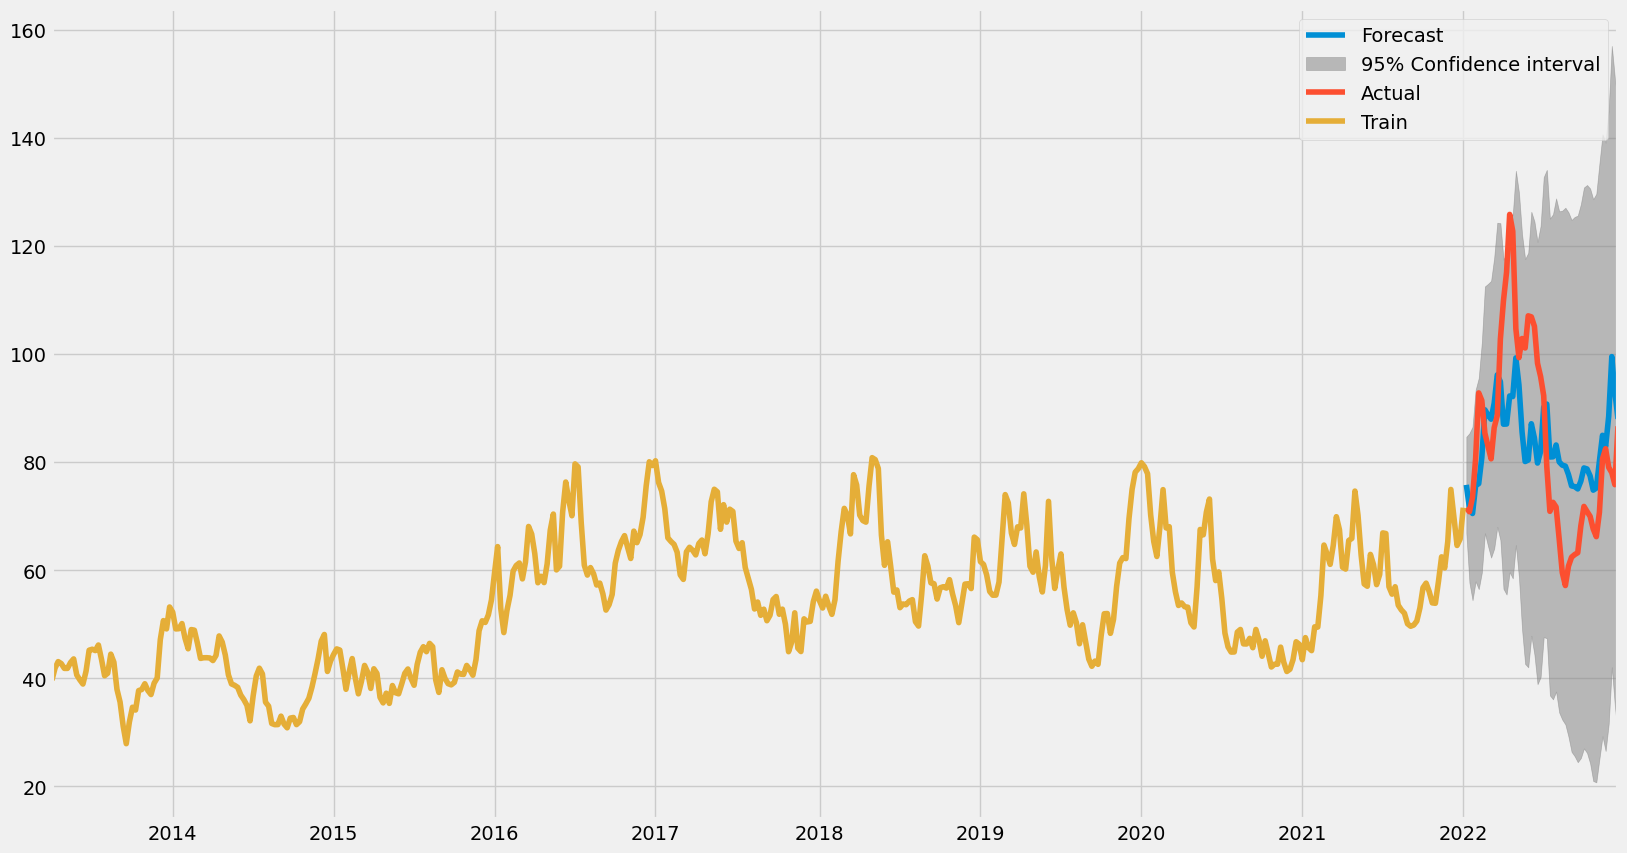

In [208]:
# Create a plot of the best SARIMAX model from above

SARIMAX_uni_best_fit = SARIMAX_uni_best.fit(disp=False)
fig, ax = plt.subplots(figsize=(18,10))
plot_predict(SARIMAX_uni_best_fit, start=457, end=506, ax=ax, exog=exogenous_test['TWI'])
test.plot(ax=ax, label='Actual')
train.plot(ax=ax)
plt.legend(['Forecast', '95% Confidence interval', 'Actual', 'Train'])
plt.savefig('Figures/ARIMA/SARIMAX_4_1_0_0_1_0_52_TWI.png')
plt.show()

In [229]:
print(SARIMAX_uni_best_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &          SalmonPrice           & \textbf{  No. Observations:  } &    457      \\
\textbf{Model:}                  & SARIMAX(4, 1, 0)x(0, 1, 0, 52) & \textbf{  Log Likelihood     } & -1184.750   \\
\textbf{Date:}                   &        Thu, 13 Apr 2023        & \textbf{  AIC                } &  2381.501   \\
\textbf{Time:}                   &            15:37:57            & \textbf{  BIC                } &  2405.509   \\
\textbf{Sample:}                 &           04-07-2013           & \textbf{  HQIC               } &  2391.005   \\
\textbf{}                        &          - 01-02-2022          & \textbf{                     } &             \\
\textbf{Covariance Type:}        &              opg               & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \te

In [221]:
%%capture

SARIMAX_multi_RMSE_df = pd.DataFrame()

P=0
D=1
Q=0
p=3
d=1
q=0

for i in exogenous_train.columns:
    for j in exogenous_train.columns:
        if i != j:
            try:
                SARIMAX_model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,52), exog=exogenous_train[[i,j]])
                SARIMAX_fit = SARIMAX_model.fit(disp=False)
                SARIMAX_forecasts = SARIMAX_fit.forecast(50, exog=exogenous_test[[i,j]])
                RMSE = np.sqrt(metrics.mean_squared_error(test, SARIMAX_forecasts))
                SARIMAX_multi_RMSE_df = SARIMAX_multi_RMSE_df.append(pd.DataFrame({'RMSE':[RMSE]}, index=['SARIMAX('+str(p)+','+str(d)+','+str(q)+')('+str(P)+','+str(D)+','+str(Q)+',52)('+i+'+'+j+')']));         
            except:
                continue;


In [222]:
SARIMAX_multi_RMSE_df.sort_values(by=['RMSE'], ascending=True).style.to_latex('Figures/ARIMA/SARIMAX_multi_RMSE_df.tex', hrules=True)

In [223]:
SARIMAX_multi_RMSE_df.sort_values(by=['RMSE'], ascending=True).head(10)

,RMSE
"SARIMAX(3,1,0)(0,1,0,52)(HalibutPrice+TWI)",14.572793
"SARIMAX(3,1,0)(0,1,0,52)(TWI+HalibutPrice)",14.572793
"SARIMAX(3,1,0)(0,1,0,52)(CodPrice+TWI)",14.702447
"SARIMAX(3,1,0)(0,1,0,52)(TWI+CodPrice)",14.702447
"SARIMAX(3,1,0)(0,1,0,52)(HalibutPrice+CodPrice)",14.942740
"SARIMAX(3,1,0)(0,1,0,52)(CodPrice+HalibutPrice)",14.942740
"SARIMAX(3,1,0)(0,1,0,52)(CPI+TWI)",15.760253
"SARIMAX(3,1,0)(0,1,0,52)(TWI+CPI)",15.760254
"SARIMAX(3,1,0)(0,1,0,52)(CPI+CodPrice)",16.054183
"SARIMAX(3,1,0)(0,1,0,52)(CodPrice+CPI)",16.054191


In [224]:
%%capture
# Create a plot from the best sarimax model using two exogenous variables

SARIMAX_multi_best = SARIMAX(train, order=(3,1,0), seasonal_order=(0,1,0,52), exog=exogenous_train[['TWI', 'HalibutPrice']])
SARIMAX_multi_best_fit = SARIMAX_multi_best.fit(disp=False)
fig, ax = plt.subplots(figsize=(18,10))
plot_predict(SARIMAX_multi_best_fit, start=457, end=506, ax=ax, exog=exogenous_test[['TWI', 'HalibutPrice']])
test.plot(ax=ax, label='Actual')
train.plot(ax=ax)
plt.legend(['Forecast', '95% Confidence interval', 'Actual', 'Train'])
plt.savefig('Figures/ARIMA/SARIMAX_3_1_0_0_1_0_52_TWI+HalibutPrice.png')


In [225]:
print(SARIMAX_multi_best_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &          SalmonPrice           & \textbf{  No. Observations:  } &    457      \\
\textbf{Model:}                  & SARIMAX(3, 1, 0)x(0, 1, 0, 52) & \textbf{  Log Likelihood     } & -1184.424   \\
\textbf{Date:}                   &        Thu, 13 Apr 2023        & \textbf{  AIC                } &  2380.847   \\
\textbf{Time:}                   &            15:33:38            & \textbf{  BIC                } &  2404.856   \\
\textbf{Sample:}                 &           04-07-2013           & \textbf{  HQIC               } &  2390.351   \\
\textbf{}                        &          - 01-02-2022          & \textbf{                     } &             \\
\textbf{Covariance Type:}        &              opg               & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                      & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$}

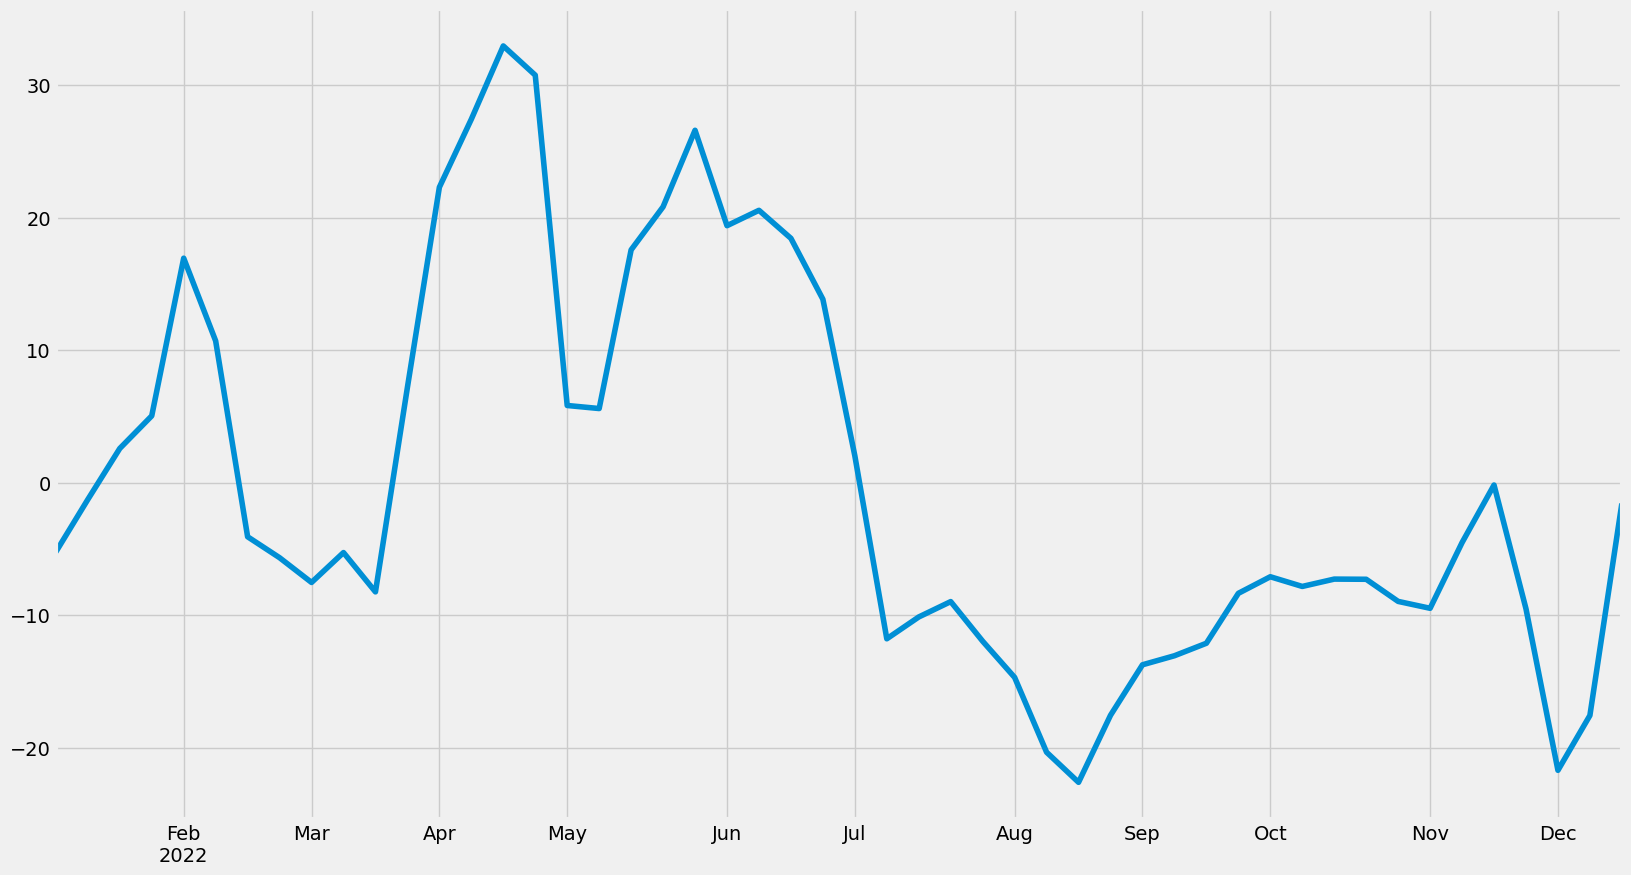

In [226]:
SARIMAX_forecasts = SARIMAX_multi_best_fit.forecast(50, exog=exogenous_test[['TWI', 'HalibutPrice']])
SARIMAX_forecasts_df = pd.DataFrame({'Actual':test, 'Predicted':SARIMAX_forecasts})
SARIMAX_forecasts_df["Difference"] = SARIMAX_forecasts_df["Actual"] - SARIMAX_forecasts_df["Predicted"]
SARIMAX_forecasts_df["Difference"].plot(figsize=(18,10))
plt.show()